In [ ]:
import numpy
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
## Neural network class
class PINN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(PINN, self).__init__()
    activation = nn.Tanh
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size),activation()) for _ in range(num_layers)])
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x, y):
    input_data = torch.cat((x, y), -1)
    output = torch.tanh(self.input_layer(input_data))
    for layer in self.hidden_layers:
      output = layer(output)
    final_output = self.output_layer(output)
    output1, output2, output3 = torch.split(final_output, 1, dim=1)
    return output1, output2, output3

In [ ]:
##Defining the Continuity Equation
def continuity_equation(u, v, x, y):
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]
    return u_x + v_y

In [ ]:
##Defining the X momentum Equation
def Xmomentum_equation(u, v, x, y, nu):
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u), create_graph=True)[0]
    return u*u_x + v*u_y - nu*u_yy

In [ ]:
##Defining the Energy Equation
def Energy_equation(u, v, x, y, T, alpha):
    T_x = torch.autograd.grad(T, x, torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, torch.ones_like(T), create_graph=True)[0]
    return u*T_x + v*T_y - alpha*T_yy

In [ ]:
## Initialization of PINN and constants
torch.manual_seed(69)
pinn = PINN(2,40,3,10)
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0005)
u0 = 1
T0 = 10
T1 = 0
nu = 0.001
alpha = nu/0.7

In [ ]:
## PDE training data
x1 = torch.linspace(0, 5, 41).view(-1, 1)
y1 = torch.linspace(0, 1, 41).view(-1, 1)
x1 = x1.view(-1)
y1 = y1.view(-1)
x_train1, y_train1 = torch.meshgrid(x1, y1)
x_train1 = x_train1.reshape(1681, 1).requires_grad_(True)
y_train1 = y_train1.reshape(1681, 1).requires_grad_(True)

In [ ]:
## y = 0 Boundary condition training data
x2 = torch.linspace(0, 5, 41).view(-1, 1)
y2 = torch.tensor(0.)
x2 = x2.view(-1)
y2 = y2.view(-1)
x_train2, y_train2 = torch.meshgrid(x2, y2)
x_train_y0 = x_train2.reshape(41, 1).requires_grad_(True)
y_train_y0 = y_train2.reshape(41, 1).requires_grad_(True)
T_train_y0 = torch.ones_like(x_train_y0)*T0
u_train_y0 = 0
v_train_y0 = 0

In [ ]:
## y = 1 Boundary condition training data
x3 = torch.linspace(0, 5, 41).view(-1, 1)
y3 = torch.tensor(1.)
x3 = x3.view(-1)
y3 = y3.view(-1)
x_train3, y_train3 = torch.meshgrid(x3, y3)
x_train_y1 = x_train3.reshape(41, 1).requires_grad_(True)
y_train_y1 = y_train3.reshape(41, 1).requires_grad_(True)
T_train_y1 = torch.ones_like(x_train_y1)*T1
u_train_y1 = u0
v_train_y1_y = 0

In [ ]:
## x = 0 Boundary condition training data
y4 = torch.linspace(0, 1, 41).view(-1, 1)
x4 = torch.tensor(0.)
x4 = x4.view(-1)
y4 = y4.view(-1)
x_train4, y_train4 = torch.meshgrid(x4, y4)
x_train_x0 = x_train4.reshape(41, 1).requires_grad_(True)
y_train_x0 = y_train4.reshape(41, 1).requires_grad_(True)
T_train_x0 = torch.ones_like(x_train_x0)*T1
u_train_x0 = u0
v_train_x0 = 0

In [ ]:
## Training Loop
epochs = 30000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  ## pde residual losses for continuity equation, momentum equation, and energy equation
  T_pred, u_pred, v_pred = pinn(x_train1, y_train1)
  pde_loss1 = continuity_equation(u_pred, v_pred, x_train1, y_train1).pow(2).mean()
  pde_loss2 = Xmomentum_equation(u_pred, v_pred, x_train1, y_train1, nu).pow(2).mean()
  pde_loss3 = Energy_equation(u_pred, v_pred, x_train1, y_train1, T_pred, alpha).pow(2).mean()
  pde_loss = pde_loss1 + pde_loss2 + pde_loss3

  ## Boundary condition losses for for boundary y = 0
  T_pred_y0, u_pred_y0, v_pred_y0 = pinn(x_train_y0, y_train_y0)
  boundary_condition_loss_y0 = (T_pred_y0 - T_train_y0).pow(2).mean() + (u_pred_y0 - u_train_y0).pow(2).mean() + (v_pred_y0 - v_train_y0).pow(2).mean()

  ## Boundary condition losses for for boundary y = 1
  T_pred_y1, u_pred_y1, v_pred_y1 = pinn(x_train_y1, y_train_y1)
  v_pred_y1_y = torch.autograd.grad(v_pred_y1, y_train_y1, torch.ones_like(v_pred_y1), create_graph=True)[0]
  boundary_condition_loss_y1 = (T_pred_y1 - T_train_y1).pow(2).mean() + (u_pred_y1 - u_train_y1).pow(2).mean() + (v_pred_y1_y - v_train_y1_y).pow(2).mean()

  ## Boundary condition losses for for boundary x = 0
  T_pred_x0, u_pred_x0, v_pred_x0 = pinn(x_train_x0, y_train_x0)
  boundary_condition_loss_x0 = (T_pred_x0 - T_train_x0).pow(2).mean() + (u_pred_x0 - u_train_x0).pow(2).mean() + (v_pred_x0 - v_train_x0).pow(2).mean()

  p1 = 1
  boundary_condition_loss = boundary_condition_loss_y0 + boundary_condition_loss_y1 + boundary_condition_loss_x0
  total_loss = pde_loss + p1*boundary_condition_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 2000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}")

Epoch 0/30000, Total Loss: 103.11575317382812, pde Loss: 1.2910894611195545e-06, Boundary Loss: 103.11575317382812
Epoch 2000/30000, Total Loss: 1.317796230316162, pde Loss: 0.04404045268893242, Boundary Loss: 1.2737557888031006
Epoch 4000/30000, Total Loss: 1.2719589471817017, pde Loss: 0.017675265669822693, Boundary Loss: 1.2542836666107178
Epoch 6000/30000, Total Loss: 1.251015305519104, pde Loss: 0.007039632182568312, Boundary Loss: 1.2439756393432617
Epoch 8000/30000, Total Loss: 1.2400343418121338, pde Loss: 0.0034155375324189663, Boundary Loss: 1.2366187572479248
Epoch 10000/30000, Total Loss: 1.235076665878296, pde Loss: 0.0019781675655394793, Boundary Loss: 1.2330985069274902
Epoch 12000/30000, Total Loss: 1.2343566417694092, pde Loss: 0.001693250611424446, Boundary Loss: 1.2326633930206299
Epoch 14000/30000, Total Loss: 1.2354332208633423, pde Loss: 0.0024169825483113527, Boundary Loss: 1.2330162525177002
Epoch 16000/30000, Total Loss: 1.2652822732925415, pde Loss: 0.03185017

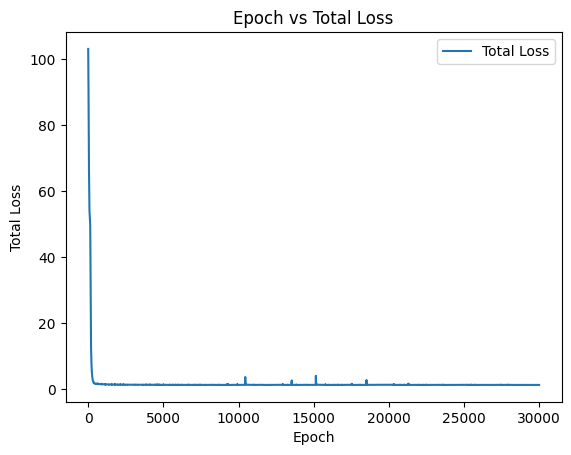

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

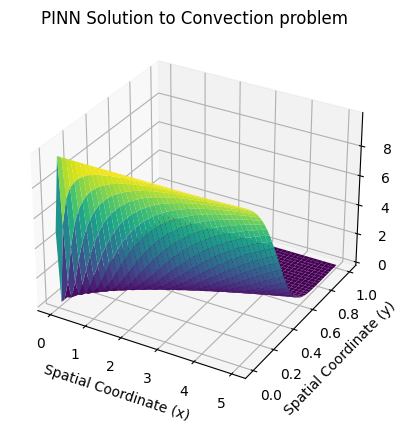

In [ ]:
with torch.no_grad():
    x_plot = torch.linspace(0, 5, 41)
    y_plot = torch.linspace(0, 1, 41)
    X, Y = torch.meshgrid(x_plot, y_plot)
    xy_combined = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)
    T_pred_plot, u_pred_plot, v_pred_plot = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), T_pred_plot.reshape(X.shape), cmap='viridis')
ax.set_xlabel('Spatial Coordinate (x)')
ax.set_ylabel('Spatial Coordinate (y)')
ax.set_zlabel('Temperature (T)')
ax.set_title('PINN Solution to Convection problem')
plt.show()

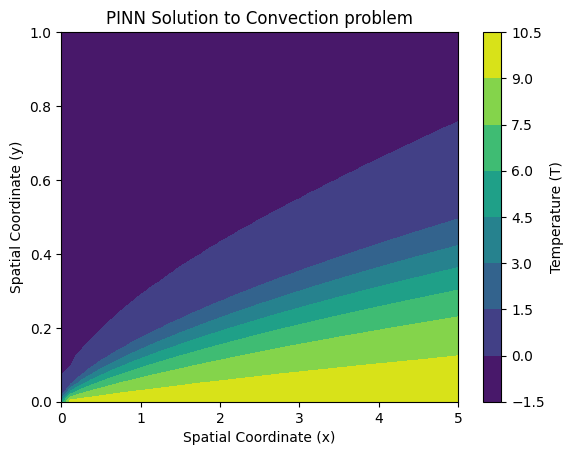

In [ ]:
## 2D contour plot
plt.figure()
contour = plt.contourf(X.numpy(), Y.numpy(), T_pred_plot.reshape(X.shape), cmap='viridis')
plt.colorbar(contour, label='Temperature (T)')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Spatial Coordinate (y)')
plt.title('PINN Solution to Convection problem')
plt.show()

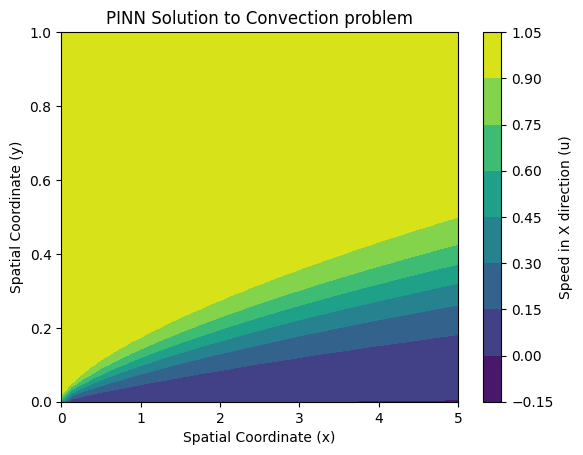

In [ ]:
## 2D contour plot
plt.figure()
contour = plt.contourf(X.numpy(), Y.numpy(), u_pred_plot.reshape(X.shape), cmap='viridis')
plt.colorbar(contour, label='Speed in X direction (u)')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Spatial Coordinate (y)')
plt.title('PINN Solution to Convection problem')
plt.show()

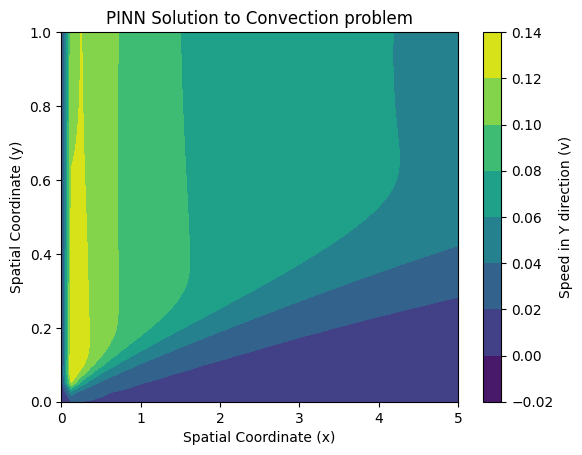

In [ ]:
## 2D contour plot
plt.figure()
contour = plt.contourf(X.numpy(), Y.numpy(), v_pred_plot.reshape(X.shape), cmap='viridis')
plt.colorbar(contour, label='Speed in Y direction (v)')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Spatial Coordinate (y)')
plt.title('PINN Solution to Convection problem')
plt.show()

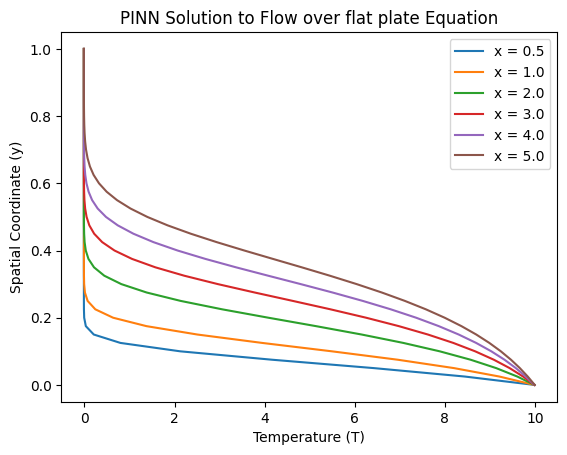

In [ ]:
with torch.no_grad():
    y_plot2 = torch.linspace(0, 1, 41)
    x_points = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

    plt.figure()

    for x_point in x_points:
        x_plot2 = torch.ones_like(y_plot2) * x_point
        xy_combined = torch.cat([x_plot2.reshape(-1, 1), y_plot2.reshape(-1, 1)], dim=1)

        T_pred_plot2, _, _ = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1))

        plt.plot(T_pred_plot2, y_plot2.numpy(), label=f'x = {x_point}')

    plt.xlabel('Temperature (T)')
    plt.ylabel('Spatial Coordinate (y)')
    plt.title('PINN Solution to Flow over flat plate Equation')
    plt.legend()
    plt.show()

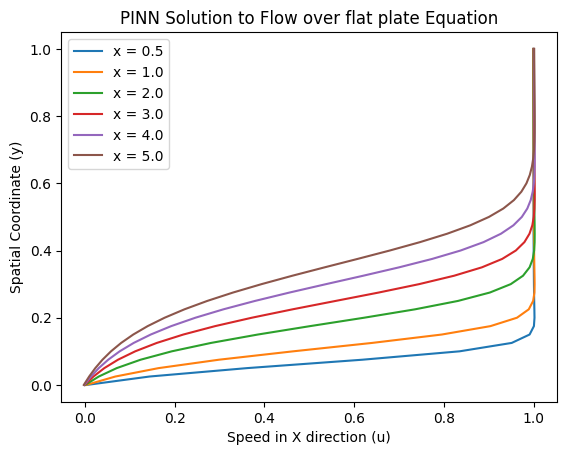

In [ ]:
with torch.no_grad():
    y_plot2 = torch.linspace(0, 1, 41)
    x_points = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

    plt.figure()

    for x_point in x_points:
        x_plot2 = torch.ones_like(y_plot2) * x_point
        xy_combined = torch.cat([x_plot2.reshape(-1, 1), y_plot2.reshape(-1, 1)], dim=1)

        _, u_pred_plot2, _ = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1))

        plt.plot(u_pred_plot2, y_plot2.numpy(), label=f'x = {x_point}')

    plt.xlabel('Speed in X direction (u)')
    plt.ylabel('Spatial Coordinate (y)')
    plt.title('PINN Solution to Flow over flat plate Equation')
    plt.legend()
    plt.show()

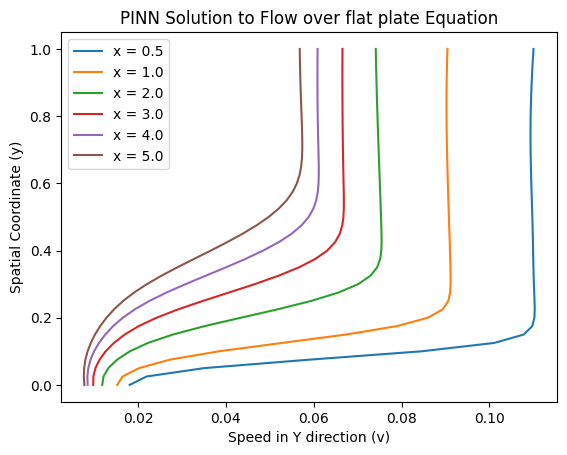

In [ ]:
with torch.no_grad():
    y_plot2 = torch.linspace(0, 1, 41)
    x_points = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

    plt.figure()

    for x_point in x_points:
        x_plot2 = torch.ones_like(y_plot2) * x_point
        xy_combined = torch.cat([x_plot2.reshape(-1, 1), y_plot2.reshape(-1, 1)], dim=1)

        _, _, v_pred_plot2 = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1))

        plt.plot(v_pred_plot2, y_plot2.numpy(), label=f'x = {x_point}')

    plt.xlabel('Speed in Y direction (v)')
    plt.ylabel('Spatial Coordinate (y)')
    plt.title('PINN Solution to Flow over flat plate Equation')
    plt.legend()
    plt.show()

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# file_path = '/content/bl_convection.txt'
# delimiter = '    '
# selected_columns = [0, 2, 4]
# selected_data = []

# import pandas as pd
# with open(file_path, 'r') as file:
#     for line_number, line in enumerate(file, 1):
#         columns = line.strip().split('    ')
#         selected_values = [columns[i] for i in selected_columns]
#         selected_data.append(selected_values)
# column_names = ['eta', 'f_prime', 'theta']
# df_selected = pd.DataFrame(selected_data, columns=column_names)

# df_copy  = df_selected
# df_copy = df_copy.astype(str)

# def apply(val):
#   val_copy = val.split('D')
#   return float(val_copy[0])*(10**(float(val_copy[1])))

# df_copy = df_copy.applymap(apply)

# column_arrays = [df_copy.iloc[:, i].to_numpy() for i in range(df_selected.shape[1])]
# column_1_array = column_arrays[0]
# column_2_array = column_arrays[1]
# column_3_array = column_arrays[2]
# column_1_array = column_1_array[::50000]
# column_2_array = column_2_array[::50000]
# column_3_array = column_3_array[::50000]
# eta_plot = torch.tensor(column_1_array, dtype=torch.float32).reshape(21,1)
# f_prime_plot = torch.tensor(column_2_array, dtype=torch.float32).reshape(21,1)
# theta_plot = torch.tensor(column_3_array, dtype=torch.float32).reshape(21,1)

In [ ]:
# eta = Y * torch.sqrt(u0/(nu*X))
# theta = (T_pred_plot - T1) / (T0 - T1)

In [ ]:
# plt.scatter(theta.reshape(1681,1).detach().numpy(), eta.reshape(1681,1).detach().numpy(), label="theta_pred", marker='o', s=3)
# plt.scatter(theta_plot, eta_plot, label='theta_actual', color='orange', marker='x')
# plt.xlabel("theta")
# plt.ylabel("eta")
# plt.legend()
# plt.show()